# Setup

In [42]:
with open('../data/names.txt') as names_file:
    words = names_file.read().splitlines()

words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [43]:
len(words)

32033

## Build Vocabulary

In [44]:
from string import ascii_lowercase

BOUNDARY = "."

vocab = [BOUNDARY] + list(ascii_lowercase)

vtoi = {v: i for i, v in enumerate(vocab)}

vtoi

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [45]:
len(vocab)

27

## Build Datasets

Training: 80%, used to train parameters

Dev: 10%, used to test hyperparameters

Test: 10%, used to evaluate model performance

In [46]:
import random
from typing import Collection, Tuple

import torch

n = 3

def build_dataset(words: "Collection[str]", n: "int" = 3) -> "Tuple[torch.Tensor, torch.Tensor]":
    X, Y = [], []
    for word in words:
        context = [0] * n
        for c in word + BOUNDARY:
            i = vtoi[c]
            X.append(context)
            Y.append(i)

            # update context (crop & append)
            context = context[1:] + [i]

    X = torch.tensor(X).short()
    Y = torch.tensor(Y).short()
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)

ix_dev = int(len(words) * 0.8)
ix_test = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:ix_dev])
Xdev, Ydev = build_dataset(words[ix_dev:ix_test])
Xtest, Ytest = build_dataset(words[ix_test:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# MLP Model

## Initialization

In [47]:
import torch

emb_size = 10 # dimensionality of the embedding
h_size = 200 # number of neurons in hidden layer

g = torch.Generator().manual_seed(2147483647)

C = torch.randn(len(vocab), emb_size, generator=g)
W1 = torch.randn(n * emb_size, h_size, generator=g) * (5/3) / (n * emb_size)**0.5
W2 = torch.randn(h_size, len(vocab), generator=g) * 0.01 # initialize with small values, creates uniform distribution of initial probabilities
b2 = torch.zeros(len(vocab)) # no initial bias, creates uniform distribution of initial probabilities

bn_gain = torch.ones((1, h_size))
bn_bias = torch.zeros((1, h_size))
bn_mean = torch.zeros((1, h_size))
bn_std = torch.ones((1, h_size))

parameters = [C, W1, W2, b2, bn_gain, bn_bias]

for p in parameters:
    p.requires_grad = True

# total parameters
sum(p.numel() for p in parameters)

12097

## Training

In [48]:
import torch.nn.functional as F

# gradient descent config
phases = 3 # learning rate decay occurs after each phase
iterations = h_size * emb_size * 16 # more parameters = more training = more iterations
initial_lr = 10**-1
batch_size = 32

# tracking
losses = []

def lr_with_decay(i):
    phase = i // iterations
    return initial_lr * (0.1 ** phase)

# learn with learning rate decay
for i in range(phases * iterations):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    uX, uY = Xtr.long()[ix], Ytr.long()[ix]

    # forward pass
    emb = C[uX] # select embeddings for mini-batch
    embcat = emb.view(-1, n * emb_size) # concatenate embeddings
    h_preact = embcat @ W1 # pre-activation of hidden layer

    # batch normalization
    h_preact_mean = h_preact.mean(dim=0, keepdim=True)
    h_preact_std = h_preact.std(dim=0, keepdim=True)
    h_norm = bn_gain * (h_preact - h_preact_mean) / h_preact_std + bn_bias

    # running update of batch normalization statistics
    with torch.no_grad():
        bn_mean = bn_mean * 0.999 + h_preact_mean * 0.001
        bn_std = bn_std * 0.999 + h_preact_std * 0.001

    h = torch.tanh(h_norm) # activation of hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, uY) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update w/ learning weight decay
    lr = lr_with_decay(i)
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    losses.append(loss.log10().item())
    if i % 10_000 == 0:
        print(f"{i} / {phases * iterations}: {loss.item():.3f}")

0 / 96000: 3.320
10000 / 96000: 2.414
20000 / 96000: 2.332
30000 / 96000: 1.997
40000 / 96000: 2.067
50000 / 96000: 1.819
60000 / 96000: 2.098
70000 / 96000: 2.298
80000 / 96000: 1.818
90000 / 96000: 2.102


## Analysis

Review pre/post activation values of hidden layer. Extreme values sent passed into the `tanh` activation function lead to a problem known as `tanh` saturation.

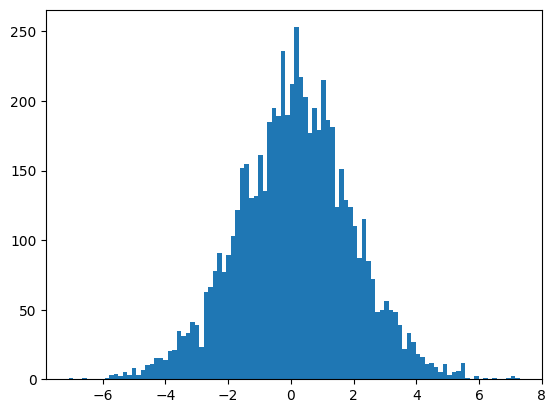

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(h_preact.view(-1).tolist(), bins=100);

`tanh` saturation occurs when most post-activation values are either `1` or `-1`. These are the extreme values of `tanh`, which causes the gradient to be zero. When the gradient is 0, backpropogation will not see any relationship between inputs and outputs across this layer. The chain rule multiplies gradients at each layer, so a gradient of `0` at any layer means the weights will not be updated. This is a problem because the model will not learn.

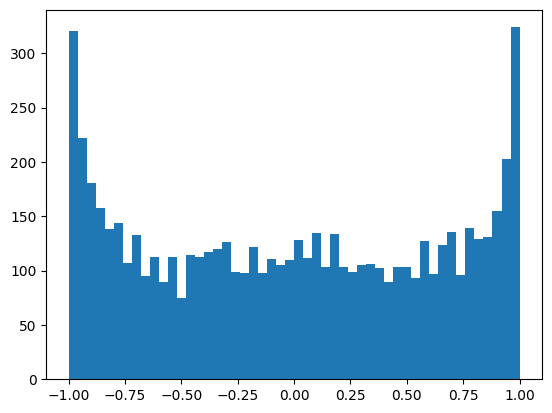

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(h.view(-1).tolist(), bins=50);

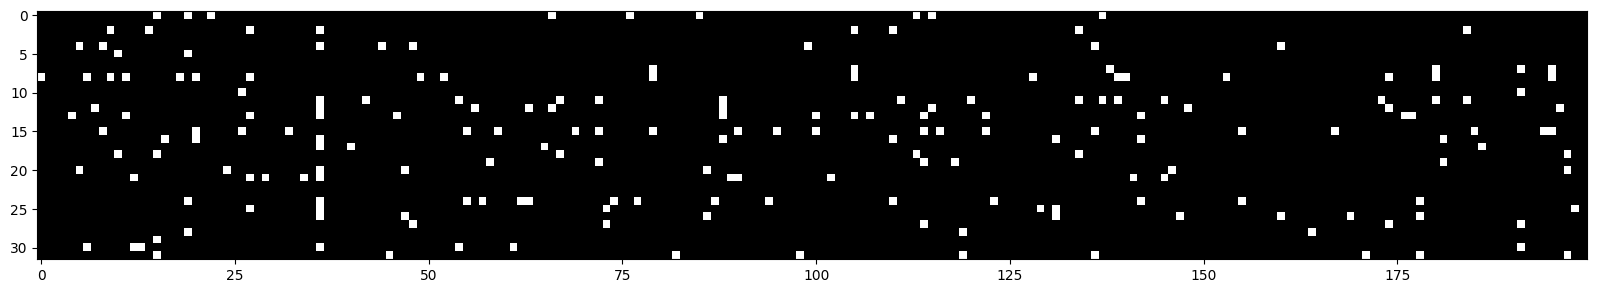

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest");

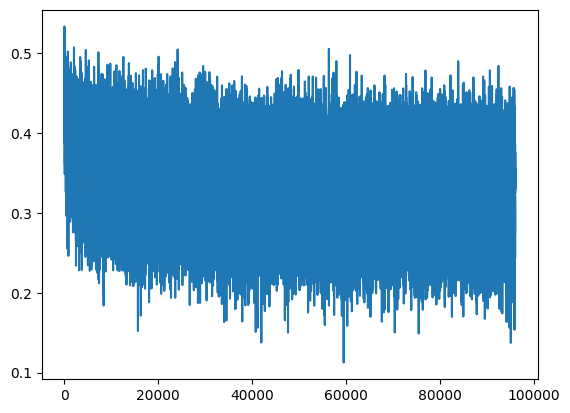

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(losses);

In [53]:
@torch.no_grad()
def split_loss(split: "str") -> "float":
    data = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xtest, Ytest),
    }

    x, y = data[split]

    emb = C[x.long()]
    embcat = emb.view(emb.shape[0], -1)
    h_preact = embcat @ W1
    h_norm = bn_gain * (h_preact - bn_mean) / bn_std + bn_bias
    h = torch.tanh(h_norm)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y.long())

    return loss.item()

f"train: {split_loss('test')} | dev: {split_loss('dev')}"

'train: 2.132725477218628 | dev: 2.133033037185669'

## Evaluation

In [54]:
from typing import Collection

g = torch.Generator().manual_seed(2147483647)

def predict_successor(context: "Collection[int]") -> "int":
    """
    input:
        context: a list of integers representing indices of previous characters in the vocabulary

    returns: index of the next character in the vocabulary
    """
    emb = C[context]
    h_preact = emb.view(1, -1) @ W1
    h_norm = bn_gain * (h_preact - bn_mean) / bn_std + bn_bias
    h = torch.tanh(h_norm)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()

    return ix

def predict_name():
    context = [0] * n
    ix = predict_successor(context)

    name = []
    while vocab[ix] != ".":
        name += vocab[ix]
        context = context[1:] + [ix]
        ix = predict_successor(context)

    return "".join(name)

for _ in range(20):
    print(predict_name())

dex
mariah
makima
kayden
mairitta
nolly
kaman
a
samiyah
javer
gotti
moriella
kinzoredo
kaley
maside
enkavion
ratls
milline
vorhelsu
dedri


# PyTorch

## Definition

In [126]:
from typing import Collection

import torch
from torch.nn import Module, Embedding, Linear, BatchNorm1d, Tanh


class Model(Module):
    def __init__(self, context_size: int, vocab_size: int, emb_size: int, hidden_size: int = 100):
        super().__init__()

        self.C = Embedding(vocab_size, emb_size)

        # input layer
        self.linear1 = Linear(context_size * emb_size, hidden_size)
        self.norm1 = BatchNorm1d(hidden_size)
        self.activation1 = Tanh()

        # hidden layer #1
        self.linear2 = Linear(hidden_size, hidden_size, bias=False)
        self.norm2 = BatchNorm1d(hidden_size)
        self.activation2 = Tanh()

        # hidden layer #2
        self.linear3 = Linear(hidden_size, hidden_size, bias=False)
        self.norm3 = BatchNorm1d(hidden_size)
        self.activation3 = Tanh()

        # hidden layer #3
        self.linear4 = Linear(hidden_size, hidden_size, bias=False)
        self.norm4 = BatchNorm1d(hidden_size)
        self.activation4 = Tanh()

        # hidden layer #4
        self.linear5 = Linear(hidden_size, hidden_size, bias=False)
        self.norm5 = BatchNorm1d(hidden_size)
        self.activation5 = Tanh()

        # output layer
        self.linear6 = Linear(hidden_size, vocab_size, bias=False)
        self.norm6 = BatchNorm1d(vocab_size)

    def __post_init__(self):
        # make output layer less confident at initialization
        with torch.no_grad():
            self.layers()[-2].weight *= 0.1

    def layers(self) -> "Collection[Module]":
        return [
            self.linear1,
            self.norm1,
            self.activation1,
            self.linear2,
            self.norm2,
            self.activation2,
            self.linear3,
            self.norm3,
            self.activation3,
            self.linear4,
            self.norm4,
            self.activation4,
            self.linear5,
            self.norm5,
            self.activation5,
            self.linear6,
            self.norm6,
        ]

    def forward(self, x: "torch.Tensor") -> "torch.Tensor":
        emb = self.C(x)
        x = emb.view(-1, n * emb_size) # concatenate embeddings
        for layer in self.layers():
            x = layer(x)
        return x

## Initialization

In [148]:
n = 3
emb_size = 10

model = Model(context_size=n, vocab_size=len(vocab), emb_size=emb_size)

for p in model.parameters():
    p.requires_grad = True

sum(p.numel() for p in model.parameters())

47124

## Single Pass

In [128]:
import torch
from torch.optim import SGD
from torch.nn.functional import cross_entropy

model.train()

g = torch.Generator().manual_seed(2147483647)
batch_size = 32
optimizer = SGD(model.parameters(), lr=0.1)

optimizer.zero_grad()

# mini-batch
ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
uX, uY = Xtr.long()[ix], Ytr.long()[ix]

# forward pass
emb = C(uX) # select embeddings for mini-batch
x = emb.view(-1, n * emb_size) # concatenate embeddings
out = [] # output tracking for later
for layer in model.layers():
    x = layer(x)
    out.append(x)

# loss
loss = cross_entropy(x, uY)

# retain output grad for visuals
for o in out:
    o.retain_grad()

# optimize
loss.backward()
optimizer.step()

loss.item()


3.5001871585845947

## Analysis

### Activiation Distribution

In [129]:
# display layer, mean, std, and saturation
for i, layer in enumerate(model.layers()[:-2]): # exclude output layers
    if isinstance(layer, Tanh):
        t = out[i]
        print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))

layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 3.22%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 3.19%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.88%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.75%
layer 14 (      Tanh): mean -0.01, std 0.64, saturated: 3.44%


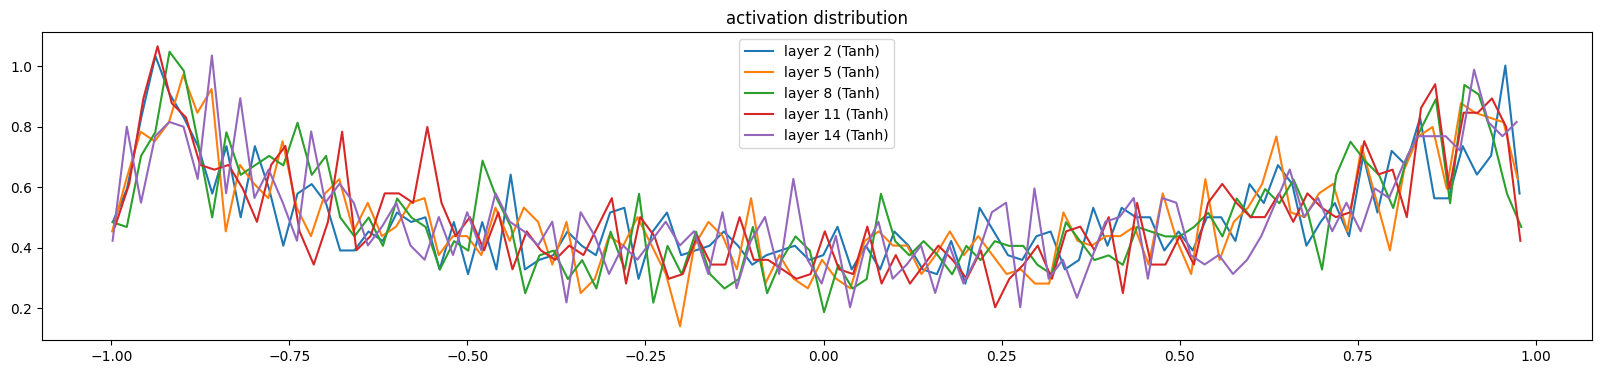

In [130]:
plt.figure(figsize=(20, 4)) # width/height of plot
plt.title("activation distribution");

# add final output for each layer to histogram
for i, layer in enumerate(model.layers()[:-2]): # exclude output layers
    if isinstance(layer, Tanh):
        t = out[i]
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())

legends = [f"layer {i} ({layer.__class__.__name__})" for i, layer in enumerate(layers[:-2]) if isinstance(layer, Tanh)]
plt.legend(legends);

### Gradient Distribution

In [131]:
# display layer, mean, and std
for i, layer in enumerate(model.layers()[:-2]): # exclude output layers
    if isinstance(layer, Tanh):
        t = out[i].grad
        print("layer %d (%10s): mean %+.2f, std %.2f" % (i, layer.__class__.__name__, t.mean(), t.std()))

layer 2 (      Tanh): mean -0.00, std 0.01
layer 5 (      Tanh): mean +0.00, std 0.01
layer 8 (      Tanh): mean +0.00, std 0.01
layer 11 (      Tanh): mean -0.00, std 0.01
layer 14 (      Tanh): mean -0.00, std 0.00


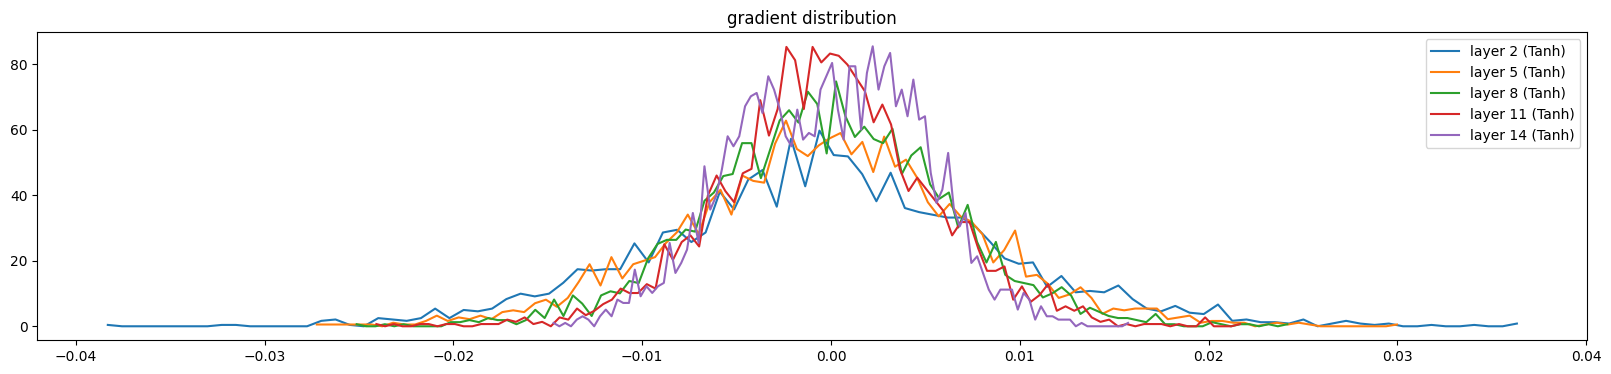

In [132]:
plt.figure(figsize=(20, 4)) # width/height of plot
plt.title("gradient distribution");

# add final output for each layer to histogram
for i, layer in enumerate(model.layers()[:-2]): # exclude output layers
    if isinstance(layer, Tanh):
        t = out[i].grad
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())

legends = [f"layer {i} ({layer.__class__.__name__})" for i, layer in enumerate(layers[:-2]) if isinstance(layer, Tanh)]
plt.legend(legends);

### Data-Gradient Ratio

In [136]:
for i, p in enumerate(model.parameters()):
    t = p.grad
    if p.ndim == 2:
        print("weight %10s | mean %+f | std %e | grad:data ratio %e" % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))

weight   (27, 10) | mean +0.000000 | std 1.012513e-02 | grad:data ratio 1.011678e-02
weight  (100, 30) | mean -0.000247 | std 1.619046e-02 | grad:data ratio 1.425372e-01
weight (100, 100) | mean +0.000027 | std 9.291596e-03 | grad:data ratio 1.446019e-01
weight (100, 100) | mean -0.000121 | std 8.165965e-03 | grad:data ratio 1.311180e-01
weight (100, 100) | mean -0.000117 | std 7.318946e-03 | grad:data ratio 1.200493e-01
weight (100, 100) | mean -0.000008 | std 7.530305e-03 | grad:data ratio 1.226452e-01
weight  (27, 100) | mean +0.000200 | std 1.462539e-02 | grad:data ratio 1.966970e-01


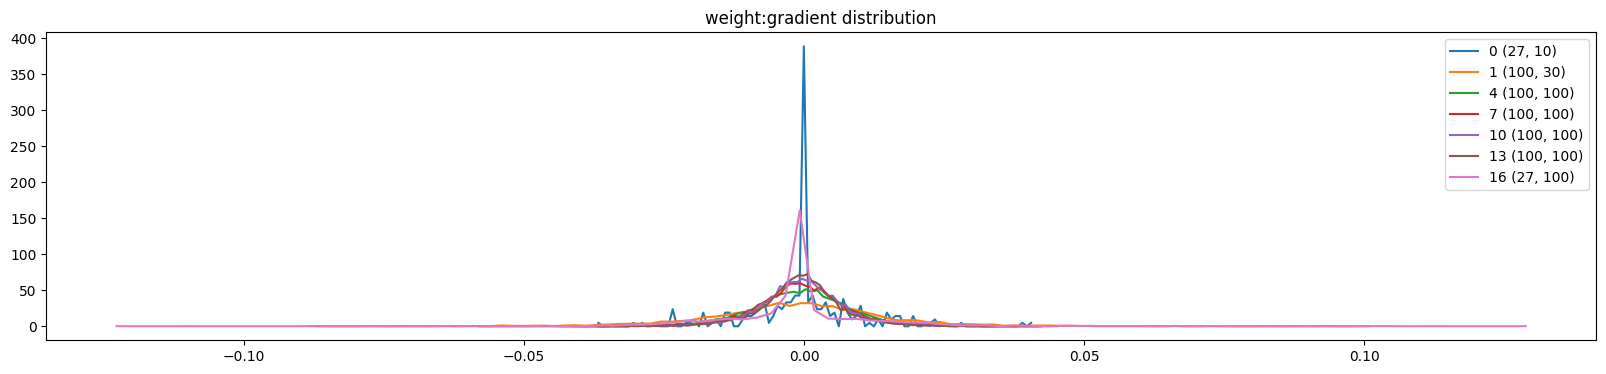

In [137]:
plt.figure(figsize=(20, 4)) # width/height of plot
plt.title("weight:gradient distribution")

for i, p in enumerate(model.parameters()):
    t = p.grad
    if p.ndim == 2:
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())

plt.legend([f"{i} {tuple(p.shape)}" for i, p in enumerate(parameters) if p.ndim == 2]);

## 1k Pass

In [135]:
import torch
from torch.nn.functional import cross_entropy

model.train()

g = torch.Generator().manual_seed(2147483647)

# gradient descent config
iterations = 1_000
batch_size = 32
lr = 0.1

optimizer = SGD(model.parameters(), lr)

# tracking
losses = []
updates = []

# learn with learning rate decay
for i in range(iterations):
    optimizer.zero_grad()

    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    uX, uY = Xtr.long()[ix], Ytr.long()[ix]

    # forward pass
    x = model(uX)

    # loss
    loss = cross_entropy(x, uY)

    # optimize
    loss.backward()
    optimizer.step()

    # track stats
    losses.append(loss.log10().item())
    with torch.no_grad():
        updates.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in model.parameters()])

## Data-Update Ratio

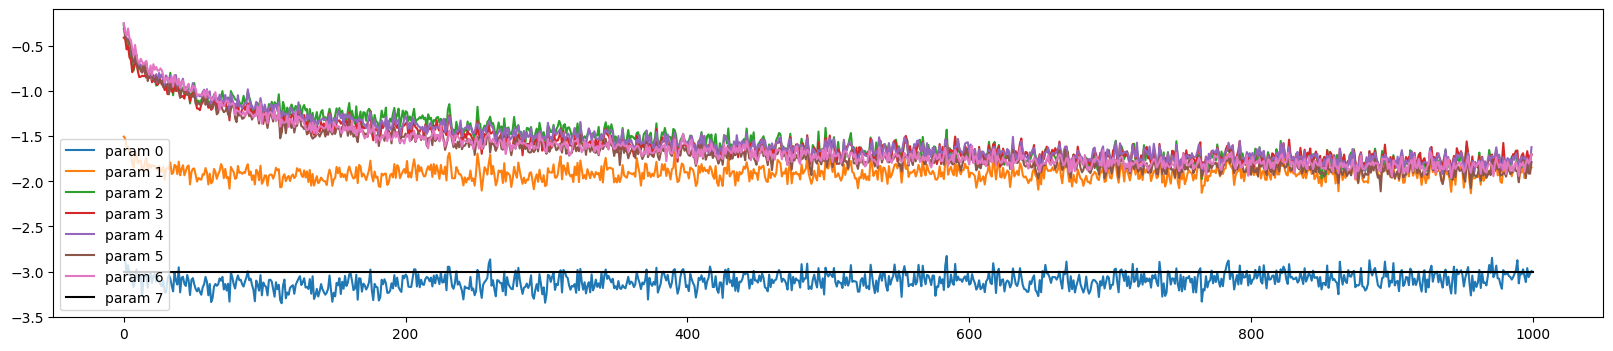

In [138]:
plt.figure(figsize=(20, 4)) # width/height of plot

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([updates[j][i] for j in range(len(updates))])

plt.plot([0, len(updates)], [-3, -3], "k") # these ratios should be ~1e-3
plt.legend(["param %d" % i for i, p in enumerate(parameters)]);

## Training

In [149]:
import torch
from torch.optim import SGD
from torch.nn.functional import cross_entropy

model.train()

g = torch.Generator().manual_seed(2147483647)

iterations = 200_000
batch_size = 32

optimizer = SGD(model.parameters(), lr=10**-1)

# learn with learning rate decay
for i in range(iterations):
    optimizer.zero_grad()

    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    uX, uY = Xtr.long()[ix], Ytr.long()[ix]

    # forward pass
    x = model(uX)
    loss = cross_entropy(x, uY)

    # optimize
    loss.backward()
    optimizer.step()

    # track stats
    if i % 20_000 == 0:
        print(f"{i} / {iterations}: {loss.item():.3f}")

0 / 200000: 3.561
20000 / 200000: 2.335
40000 / 200000: 1.988
60000 / 200000: 2.033
80000 / 200000: 2.132
100000 / 200000: 2.067
120000 / 200000: 2.197
140000 / 200000: 2.164
160000 / 200000: 2.072
180000 / 200000: 2.446


In [150]:
data = {
    "train": (Xtr, Ytr),
    "dev": (Xdev, Ydev),
    "test": (Xtest, Ytest),
}

@torch.no_grad()
def split_loss(split: "str") -> "float":
    x, y = data[split]

    # forward pass
    x = model(x.long())
    loss = cross_entropy(x, y.long())

    return loss.item()

f"train: {split_loss('test')} | dev: {split_loss('dev')}"

'train: 2.091123342514038 | dev: 2.0933330059051514'

## Evaluation

In [151]:
from typing import Collection
import torch
from torch.nn.functional import softmax

g = torch.Generator().manual_seed(2147483647)

model.eval()

@torch.inference_mode()
def predict_successor(context: "Collection[int]") -> "int":
    """
    input:
        context: a list of integers representing indices of previous characters in the vocabulary

    returns: index of the next character in the vocabulary
    """
    logits = model(torch.tensor(context, dtype=torch.long))
    probs = softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g)
    
    return ix.item()

def predict_name():
    context = [0] * n
    ix = predict_successor(context)

    name = []
    while vocab[ix] != ".":
        name += vocab[ix]
        context = context[1:] + [ix]
        ix = predict_successor(context)

    return "".join(name)

for _ in range(20):
    print(predict_name())

dex
mariah
makima
kayden
maishana
nylandrika
da
samiyah
jaxson
mari
moriella
kinzleedoren
emma
sade
enkavion
zakbse
hunite
viah
ash
dedri
